# Read Data

In [140]:
import sys
# sys.path.append("/kaggle/input/python-helpers/")
sys.path.append("../")
import common_utils
from common_utils import (
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc # For EDA
)
from optiver_utils import (
    zero_sum, clean_df, filter_df
)

In [141]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
import plotly.express as px
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [142]:
DATA_DIR = '../data/'

In [143]:
%%time
train = pd.read_parquet(f'{DATA_DIR}/optiver-train-data/clipped_train.parquet')

CPU times: user 308 ms, sys: 130 ms, total: 438 ms
Wall time: 87.1 ms


In [144]:
%%time
revealed_targets = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
test = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/test.csv')
sample_submission = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

CPU times: user 44 ms, sys: 8.66 ms, total: 52.7 ms
Wall time: 52.2 ms


In [145]:
weight_df = pd.read_csv(f"{DATA_DIR}/optiver-train-data/stock_weight.csv")
median_vol = pd.read_csv(f"{DATA_DIR}/optiver-memoryreduceddatasets/MedianVolV2.csv")
median_vol.index.name = "stock_id"
median_vol = median_vol[['overall_medvol', "first5min_medvol", "last5min_medvol"]]

In [146]:
%%time
prev_day_target_stats = train.groupby(["stock_id", "date_id"])["target"].agg(["mean", "std", "min", "median", "max"])
prev_day_target_stats = prev_day_target_stats.groupby("stock_id").shift(1).add_prefix("ytd_target_").reset_index()

CPU times: user 223 ms, sys: 40.1 ms, total: 263 ms
Wall time: 289 ms


In [147]:
%%time
median_bid_ask_size = train.groupby('stock_id').agg(median_bid_size=("bid_size", "median"), median_ask_size=("ask_size", "median")).sum(axis=1).rename("median_bid_ask_size").reset_index()
std_bid_ask_size = train.groupby('stock_id').agg(std_bid_size=("bid_size", "std"), std_ask_size=("ask_size", "std")).sum(axis=1).rename("std_bid_ask_size").reset_index()

CPU times: user 195 ms, sys: 32.2 ms, total: 227 ms
Wall time: 235 ms


In [148]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
train = train.sort_values(["stock_id", "date_id"]).reset_index(drop=True)

In [171]:
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
from IPython.display import display
sns.set_theme()

In [ ]:
def plot_multiple_cfips(df, column="mbd", cfips_list=np.arange(1001, 1011, 2)):
    plt.figure(figsize=(19, 7))
    temp = df.loc[df["cfips"].isin(cfips_list)]
    for cfips, cfips_df in temp.groupby("cfips"):
        plt.plot(cfips_df["date_id"], cfips_df[column], label=cfips)
    plt.legend()
    plt.show()

In [203]:
stock_date_df = filter_df(train, stock_id=0, date_id=1)
stock_date_df["imb_size_1st_order_diff"] = (stock_date_df["imb_size"] * stock_date_df["imb_flag"]).diff(1) 
stock_date_df["matched_size_1st_order_diff"] = stock_date_df["matched_size"].diff(1)
stock_date_df["match_imb_change_diff"] = (stock_date_df["matched_size_1st_order_diff"] + stock_date_df["imb_size_1st_order_diff"])

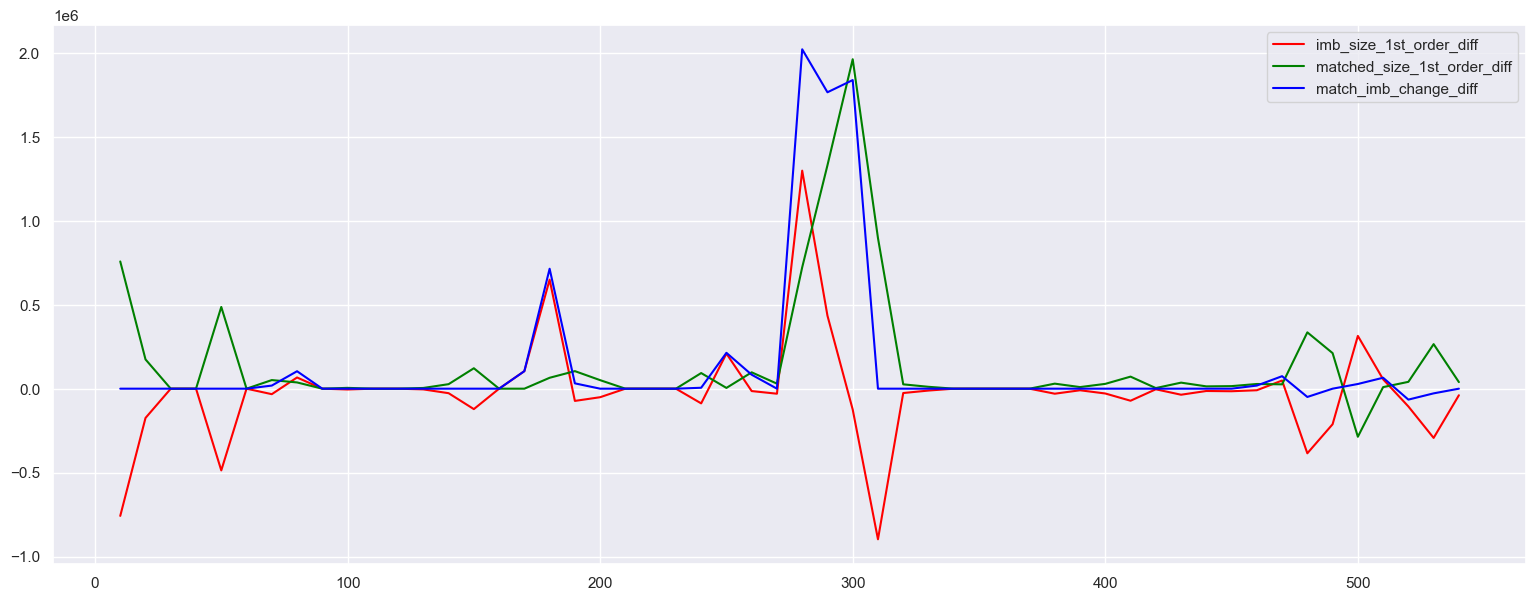

In [204]:
fig, ax = plt.subplots(figsize=(19, 7))
for col, color in zip(["imb_size_1st_order_diff", "matched_size_1st_order_diff", "match_imb_change_diff"], ["red", "green", "blue"]):
    ax.plot(stock_date_df["seconds"], stock_date_df[col], label=col, color=color)
plt.legend()
plt.show()

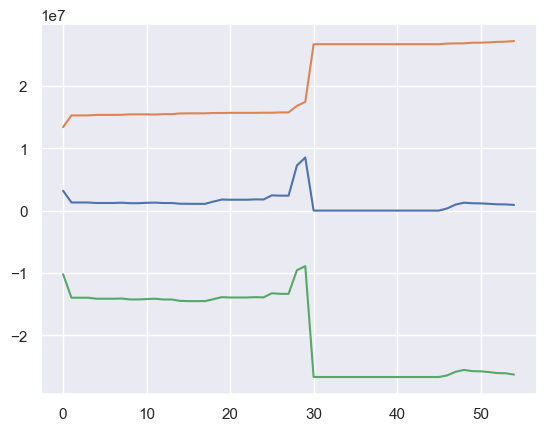

In [175]:
["imb_size"].plot()
stock_date_df["matched_size"].plot()
stock_date_df["fulfilled_size"].plot()
plt.show()

In [45]:
tr.groupby("stock_id")

In [92]:
stock_id = 3

In [93]:
def get_variable_name(variable):
    for name in globals():
        if id(globals()[name]) == id(variable):
            return name
    for name in locals():
        if id(locals()[name]) == id(variable):
            return name
    return None

In [105]:
import inspect

In [106]:
def get_variable_name(variable):
    frame = inspect.currentframe()
    while frame:
        if variable in frame.f_locals:
            return frame.f_locals[variable]
        frame = frame.f_back
    return None

In [111]:
import traceback

def get_variable_name(variable):
    for line in traceback.format_stack():
        if "in <module>" in line:
            break
        if variable in line:
            return line.split("=")[0].strip()
    return None

In [115]:
x = 5
get_variable_name = lambda x: f"{x=}".split("=")[0]
get_variable_name(x)

'x'

In [116]:
# if date_id is None:
#     date_id_cond = ~df["date_id"].isnull()
# elif isinstance(date_id, int):
#     date_id_cond = (df["date_id"] == date_id)
# elif isinstance(date_id, str):
#     date_id_cond = (df["date_id"] == int(date_id))
# elif isinstance(date_id, tuple):
#     if len(date_id) == 2:
#         date_id_cond = df["date_id"].between(date_id[0], date_id[1])
#     else:
#         print("date_id tuple shouldn't have more than 2 dimension")
# elif isinstance(date_id, list):
#     date_id_cond = df["date_id"].isin(date_id)

In [122]:
filter_df(train, stock_id=[1, 2, 3])

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wa_price,target,clipped_target,is_positive_target,is_mild_target,bid_ask_spread,bid_ask_size_gap,bid_ask_volume_diff
26455,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,1.000660,20605.089844,1.000000,-5.519986,-5.519986,0,0,0.000764,17372.050781,17372.050781
26456,1,0,10,1.659232e+05,-1,0.999955,1642895.00,NaN,NaN,0.999896,...,1.000660,33717.421875,0.999973,-1.620054,-1.620054,0,1,0.000764,29973.902344,29973.902344
26457,1,0,20,1.659232e+05,-1,0.999955,1642895.00,NaN,NaN,0.999896,...,1.000660,33717.421875,0.999973,-6.459951,-6.459951,0,0,0.000764,29973.902344,29973.902344
26458,1,0,30,1.659232e+05,-1,0.999896,1642895.00,NaN,NaN,0.999896,...,1.000308,3574.830078,1.000120,-5.149841,-5.149841,0,0,0.000412,-679.169922,-679.169922
26459,1,0,40,1.623495e+05,-1,0.999955,1646468.75,NaN,NaN,0.999896,...,1.000308,3574.830078,1.000248,-6.750226,-6.750226,0,0,0.000412,-17695.169922,-17695.169922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105815,3,480,500,3.816029e+06,-1,0.999161,73555392.00,0.998338,0.998386,0.999161,...,0.999258,24770.400391,0.999239,1.720190,1.720190,1,1,0.000097,-78223.203125,-78223.203125
105816,3,480,510,3.904030e+06,-1,0.999258,73467392.00,0.998338,0.998435,0.999258,...,0.999355,225845.359375,0.999280,4.669428,4.669428,1,0,0.000097,157313.921875,157313.921875
105817,3,480,520,3.650977e+06,-1,0.999113,73720448.00,0.998338,0.998386,0.999113,...,0.999209,220239.468750,0.999139,5.639791,5.639791,1,0,0.000096,138096.250000,138096.250000
105818,3,480,530,3.650977e+06,-1,0.999113,73720448.00,0.998338,0.998483,0.999113,...,0.999209,279479.125000,0.999139,5.229712,5.229712,1,0,0.000096,173188.281250,173188.281250


In [50]:
tr.loc[tr["stock_id"] == None]

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wa_price,target,clipped_target,is_positive_target,is_mild_target,bid_ask_spread,bid_ask_size_gap,bid_ask_volume_diff


In [49]:
plt.plot(tr["seconds"]

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wa_price,target,clipped_target,is_positive_target,is_mild_target,bid_ask_spread,bid_ask_size_gap,bid_ask_volume_diff
0,0,0,0,3.180603e+06,1,0.999812,13380277.0,NaN,NaN,0.999812,...,1.000026,8493.030273,1.000000,-3.029704,-3.029704,0,1,0.000214,-52158.468750,-52158.468750
1,0,0,10,1.299773e+06,1,1.000026,15261107.0,NaN,NaN,0.999812,...,1.000026,23519.160156,0.999892,0.389814,0.389814,1,1,0.000214,9522.660156,9522.660156
2,0,0,20,1.299773e+06,1,0.999919,15261107.0,NaN,NaN,0.999812,...,0.999919,12131.599609,0.999842,4.220009,4.220009,1,1,0.000107,7466.099609,7466.099609
3,0,0,30,1.299773e+06,1,1.000133,15261107.0,NaN,NaN,1.000026,...,1.000133,46203.300781,1.000085,5.450249,5.450249,1,0,0.000107,-9794.699219,-9794.699219
4,0,0,40,1.218204e+06,1,1.000455,15342675.0,NaN,NaN,1.000241,...,1.000455,26610.449219,1.000317,3.169775,3.169775,1,1,0.000214,11954.499023,11954.499023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79360,2,480,500,3.760113e+05,-1,0.998607,10889582.0,0.99804,0.998195,0.998555,...,0.998865,190117.796875,0.998589,-4.450083,-4.450083,0,1,0.000310,166869.000000,166869.000000
79361,2,480,510,3.760113e+05,-1,0.998607,10889582.0,0.99804,0.998195,0.998555,...,0.998865,214149.000000,0.998633,-5.559921,-5.559921,0,0,0.000310,142465.203125,142465.203125
79362,2,480,520,2.605692e+05,-1,0.998401,11005024.0,0.99804,0.998143,0.998401,...,0.998813,105034.179688,0.998405,-5.310178,-5.310178,0,0,0.000412,104065.632812,104065.632812
79363,2,480,530,1.841252e+05,-1,0.998246,11081468.0,0.99804,0.998143,0.998246,...,0.998555,63740.460938,0.998249,-5.239844,-5.239844,0,0,0.000309,63159.421875,63159.421875


In [48]:
tr["target"]

0       -3.029704
1        0.389814
2        4.220009
3        5.450249
4        3.169775
           ...   
79360   -4.450083
79361   -5.559921
79362   -5.310178
79363   -5.239844
79364   -1.549721
Name: target, Length: 79365, dtype: float32

In [46]:
tr.groupby(["stock_id", "date_id"])["target"].rolling(10).transform(lambda x: list(x)

0       -3.029704
1        0.389814
2        4.220009
3        5.450249
4        3.169775
           ...   
79360         NaN
79361         NaN
79362         NaN
79363         NaN
79364         NaN
Name: target, Length: 79365, dtype: float32

In [36]:
train.groupby(["stock_id", "date_id"])

In [35]:
train.groupby(["stock_id", "date_id"])["target"].agg(["mean", "median", "max", "min", "std"]).shift(1).add_prefix("stock_date_target_").reset_index()


,stock_id,date_id,stock_date_target_mean,stock_date_target_median,stock_date_target_max,stock_date_target_min,stock_date_target_std
0,0,0,NaN,NaN,NaN,NaN,NaN
1,0,1,-0.734535,0.020266,9.759665,-10.679960,4.185723
2,0,2,0.328942,1.009703,6.799698,-14.089942,4.007034
3,0,3,-0.326709,0.040531,8.629560,-15.569925,5.143942
4,0,4,-3.225099,-3.870130,8.759499,-17.899872,5.174628
...,...,...,...,...,...,...,...
95231,199,476,-0.323101,0.300407,11.149645,-12.249947,5.552137
95232,199,477,0.966506,0.740290,12.860298,-10.579824,5.772027
95233,199,478,-4.226024,-4.870296,3.709793,-15.050173,4.536808
95234,199,479,1.323125,1.920462,13.500452,-11.900067,5.631495


In [ ]:
stock_date_target_stats = 

In [ ]:
%%time

stock_date_target_stats = train.groupby(["stock_id", "date_id"])["target"].agg(["mean", "median", "max", "min", "std"]).shift(1).add_prefix("stock_date_target_").reset_index()
date_target_stats = stock_date_target_stats.sort_values(
    ["date_id", "stock_id"]
).reset_index(drop=True).drop(columns="stock_id").groupby("date_id").agg(["mean", "median", "max", "min", "std"])
date_target_stats.columns = ['_'.join(col).replace("stock_", "") if isinstance(col, tuple) else col for col in date_target_stats.columns]
stock_date_target_stats = stock_date_target_stats.merge(date_target_stats, on="date_id", how="left")
s = stock_date_target_stats
for sdc in get_cols(stock_date_target_stats, startswith="stock_", excludes="id"):
    # print(stock_date_col)
    mean_ = sdc.replace("stock_", "") + "_mean"
    median_ = sdc.replace("stock_", "") + "_median"
    std_ = sdc.replace("stock_", "") + "_std"
    min_ = sdc.replace("stock_", "") + "_min"
    max_ = sdc.replace("stock_", "") + "_max"
    stock_date_target_stats[f"normalized_{sdc}"] = (s[sdc] - s[mean_]) / s[std_]
    stock_date_target_stats[f"normalized_{sdc}2"] = (s[sdc] - s[median_]) / (s[max_] - s[min_])

In [25]:
train["bid_ask_volume_diff"] = (train["ask_size"] - train["bid_size"])
train["bid_ask_spread"] = (train["ask_price"] - train["bid_price"])

In [24]:
train.groupby("stock_id")["bid_ask_volume_diff"].median().describe()

count     200.000000
mean      310.449951
std      1458.317017
min     -8198.406250
25%         6.562500
50%       181.159668
75%       637.720764
max      8459.312500
Name: bid_ask_volume_diff, dtype: float64

In [26]:
train.groupby("stock_id")["bid_ask_spread"].median().describe()

count    200.000000
mean       0.000470
std        0.000348
min        0.000067
25%        0.000253
50%        0.000365
75%        0.000592
max        0.002575
Name: bid_ask_spread, dtype: float64

In [ ]:
train.groupby("stock_id")["bid_ask_spread"].median()

<Axes: xlabel='bid_ask_spread', ylabel='target'>

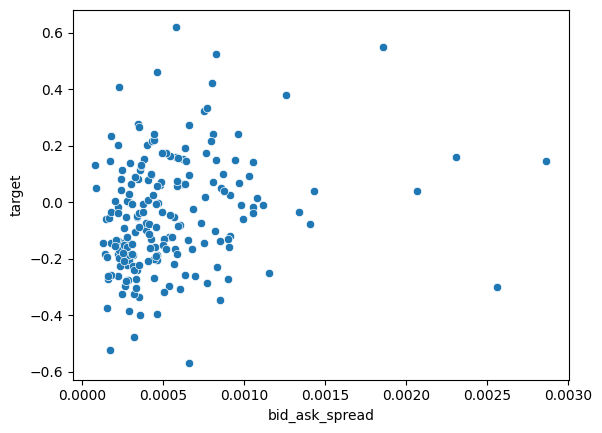

In [32]:
sns.scatterplot(x=train.groupby("stock_id")["bid_ask_spread"].mean(), y=train.groupby("stock_id")["target"].mean())

In [ ]:
train.groupby("stock_id")["bid_ask_spread"].median().describe()

In [14]:
train.groupby("stock_id")["bid_size"].median() + train.groupby("stock_id")["ask_size"].median()

stock_id
0       42739.160156
1       25548.500000
2       26228.099609
3       41667.000000
4       34014.580078
           ...      
195     51941.548828
196     42476.951172
197     30070.040039
198    304739.250000
199    114127.101562
Length: 200, dtype: float64

# Preprocessing

## Merge Additional Data

In [24]:
def merge_additional_info(df, pdts=prev_day_target_stats):
    # Merge additional static information
    df = df.merge(weight_df, on="stock_id", how="left")
    df = df.merge(median_vol, left_on="stock_id", right_index=True, how="left")
    df = df.merge(median_bid_ask_size, on="stock_id", how="left")
    df = df.merge(std_bid_ask_size, on="stock_id", how="left")
    
    # Merge additional dynamic information
    df = df.merge(pdts, on=["stock_id", "date_id"], how="left")
    return df

In [25]:
%%time
train = merge_additional_info(train)

CPU times: user 1.1 s, sys: 1.09 s, total: 2.18 s
Wall time: 2.44 s


In [30]:
for col in train.columns[2:]:
    check_auc(train, col=col, target_col="is_mild_target", verbose=True)
    print()

The AUC of seconds on is_mild_target is 0.5261

0.004% of the data dropped due to NA in imb_size
The AUC of imb_size on is_mild_target is 0.5081

The AUC of imb_flag on is_mild_target is 0.4952 (effective AUC - 0.5048)

0.004% of the data dropped due to NA in ref_price
The AUC of ref_price on is_mild_target is 0.4962 (effective AUC - 0.5038)

0.004% of the data dropped due to NA in matched_size
The AUC of matched_size on is_mild_target is 0.5658

55.257% of the data dropped due to NA in far_price
The AUC of far_price on is_mild_target is 0.4927 (effective AUC - 0.5073)

54.547% of the data dropped due to NA in near_price
The AUC of near_price on is_mild_target is 0.4924 (effective AUC - 0.5076)

0.004% of the data dropped due to NA in bid_price
The AUC of bid_price on is_mild_target is 0.5070

The AUC of bid_size on is_mild_target is 0.5299

0.004% of the data dropped due to NA in ask_price
The AUC of ask_price on is_mild_target is 0.4853 (effective AUC - 0.5147)

The AUC of ask_size o

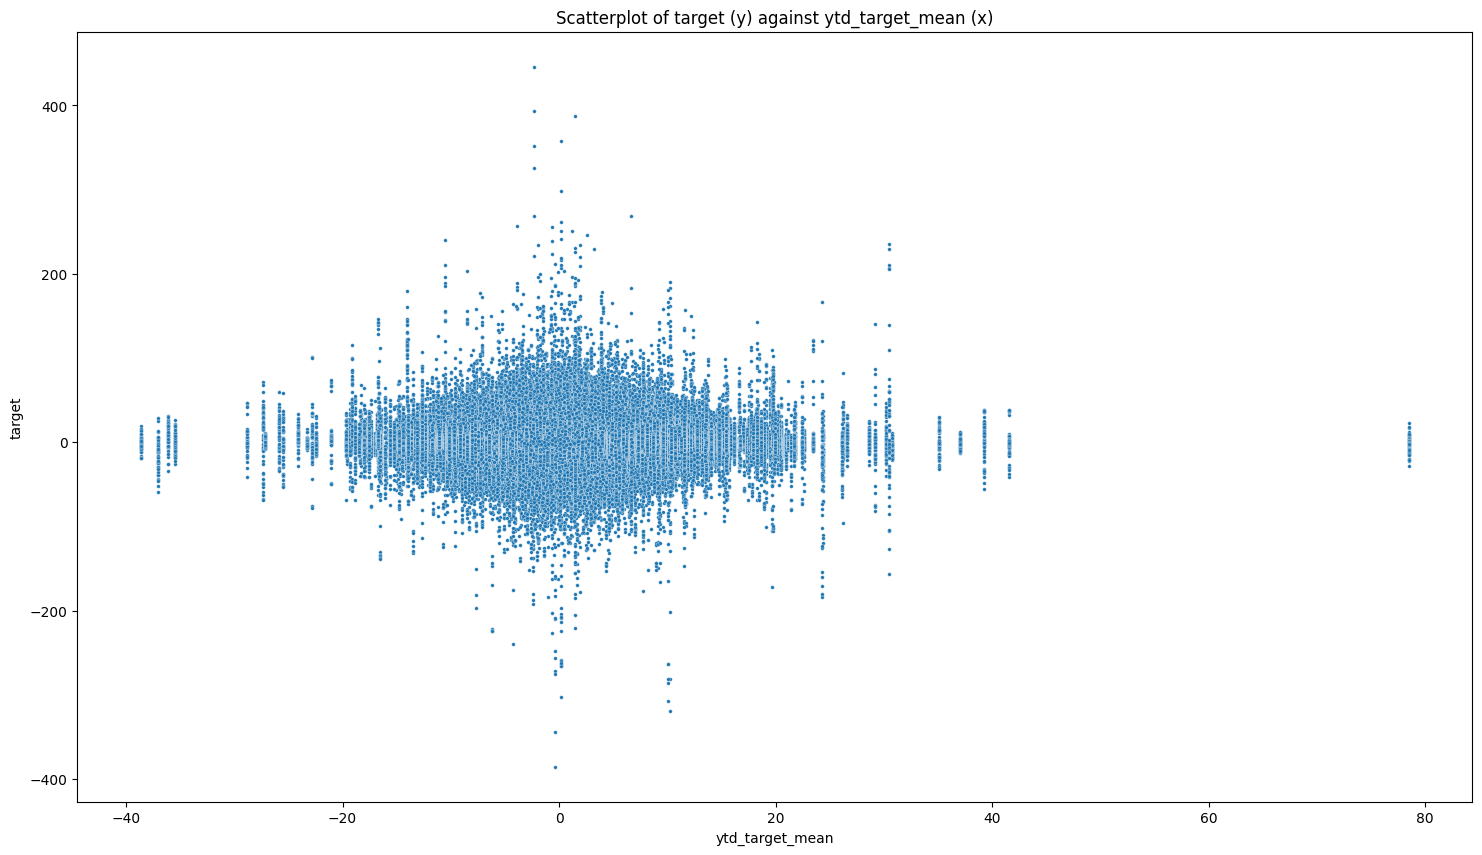

In [32]:
plot_scatterplot(train, "ytd_target_mean", "target")

In [40]:
for col in train.columns[2:]:
    check_auc(train, col, "binary_target")
    print()

The AUC of seconds on binary_target is 0.4984 (effective AUC - 0.5016)

0.004% of the data dropped due to NA in imb_size
The AUC of imb_size on binary_target is 0.4990 (effective AUC - 0.5010)

The AUC of imb_flag on binary_target is 0.5073

0.004% of the data dropped due to NA in ref_price
The AUC of ref_price on binary_target is 0.4958 (effective AUC - 0.5042)

0.004% of the data dropped due to NA in matched_size
The AUC of matched_size on binary_target is 0.4990 (effective AUC - 0.5010)

55.257% of the data dropped due to NA in far_price
The AUC of far_price on binary_target is 0.4976 (effective AUC - 0.5024)

54.547% of the data dropped due to NA in near_price
The AUC of near_price on binary_target is 0.4979 (effective AUC - 0.5021)

0.004% of the data dropped due to NA in bid_price
The AUC of bid_price on binary_target is 0.4935 (effective AUC - 0.5065)

The AUC of bid_size on binary_target is 0.4662 (effective AUC - 0.5338)

0.004% of the data dropped due to NA in ask_price
The A

In [34]:
train['feature_group'] = pd.qcut(
    train['ytd_target_mean'], q=15, duplicates="drop"
).cat.codes.replace(-1, np.nan)

In [68]:
train["memang_random"] = np.random.rand(train.shape[0])
train_subset = train.sample(100_000)

In [ ]:
def test_chi_square_contigency():

In [69]:
train_subset['target_group'] = pd.qcut(train_subset['target'], q=5, duplicates="drop").cat.codes.replace(-1, np.nan)

In [86]:
# Perform the chi-squared independence test
train_subset['feature_group'] = pd.qcut(train_subset['bid_size'], q=10, duplicates="drop").cat.codes.replace(-1, np.nan)
table = pd.crosstab(train_subset['feature_group'], train_subset['target_group'])
chi2, p, dof, expected = chi2_contingency(table)
p

2.36166859520344e-180

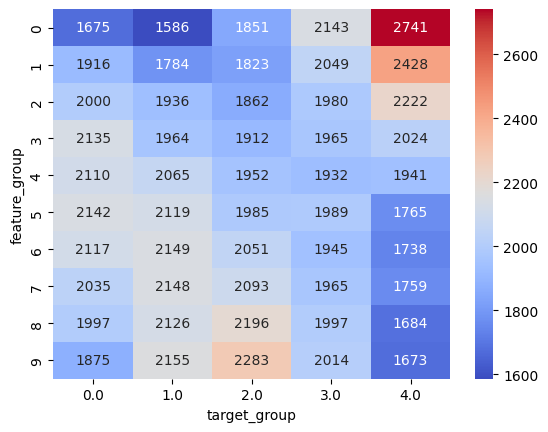

In [87]:
sns.heatmap(table, cmap="coolwarm", fmt=".0f", annot=True)
plt.show()

In [37]:
# feature_imp_df.iloc[-50:]

In [42]:
# plot_scatterplot(train, "seconds", FINAL_TARGET_COLUMN)

In [39]:
train["binary_target"].value_counts(normalize=True)

binary_target
0    0.504259
1    0.495741
Name: proportion, dtype: float64